In [ ]:
#Librerie importate
!pip install SimpleITK
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

Processing factor 1...
Processing factor 2...
Processing factor 4...
Processing factor 8...
   factor      dice   hausdorff  avg_surface_dist        hd95
0       1  1.000000    0.000000          0.000000    0.000000
1       2  0.188834  190.364453         32.177246  190.364453
2       4  0.072136  205.917805         36.431024  205.917805
3       8  0.050162  205.450837         42.738981  205.450837


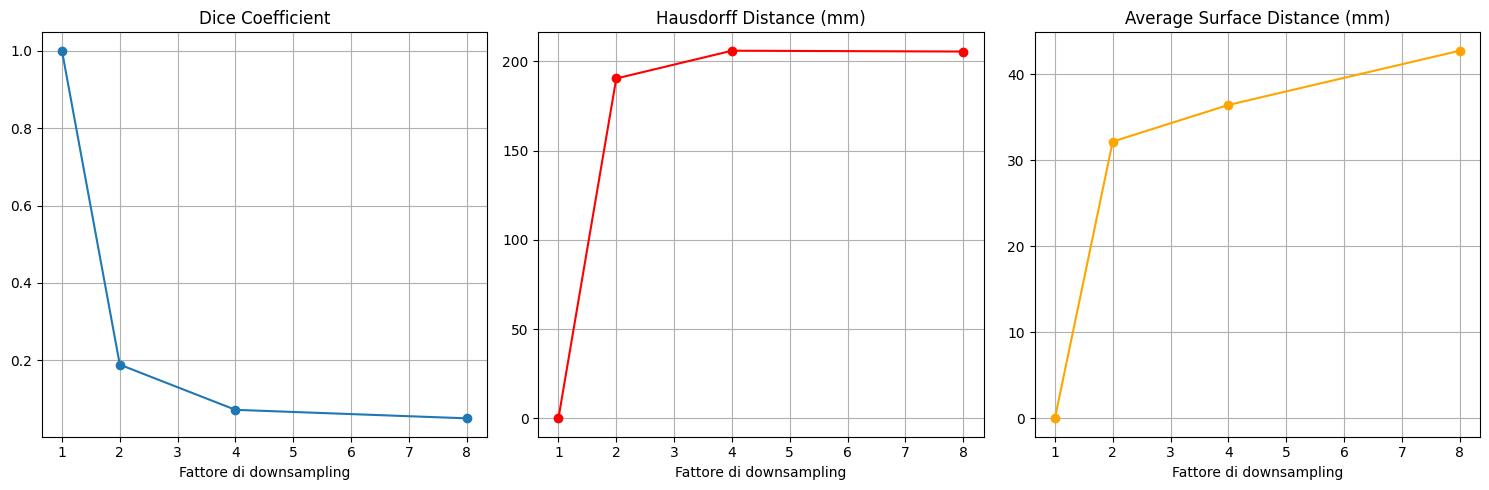

In [ ]:
'''
Il sottocampionamento spaziale introduce una perdita di accuratezza dei contorni, particolarmente evidente nelle metriche basate sulla distanza (Hausdorff),
mentre metriche di sovrapposizione come il Dice possono rimanere relativamente elevate anche in presenza di errori locali significativi.
'''

# -----------------------------
# Parametri da modificare
# -----------------------------
image_path = '/img1.nrrd'      # Immagine originale (grayscale)
label_path = '/img2.nrrd' # Maschera di segmentazione (label, es. 0=background, 1=oggetto)

# Fattori di downsampling da testare
downsample_factors = [1, 2, 4, 8]  # 1 = originale (nessun downsampling)

# Label dell'oggetto di interesse (di solito 1)
foreground_label = 1

# -----------------------------
# Funzione per resample (downsample + upsample)
# -----------------------------
def resample_to_original(img, factor):
    if factor == 1:
        return img

    original_spacing = img.GetSpacing()
    original_size = img.GetSize()

    # Downsampling: aumentiamo lo spacing
    new_spacing = tuple(s * factor for s in original_spacing)

    # Calcoliamo la nuova size (arrotondiamo per eccesso e cast a int)
    new_size = tuple(max(1, int(round(os * os_spacing / ns)))
                     for os, os_spacing, ns in zip(original_size, original_spacing, new_spacing))

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputOrigin(img.GetOrigin())
    resampler.SetOutputDirection(img.GetDirection())
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)

    # Interpolatore diverso per immagine e label
    if img.GetPixelIDTypeAsString().lower().find('label') != -1:
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resampler.SetInterpolator(sitk.sitkLinear)

    downsampled = resampler.Execute(img)

    # Upsampling: torniamo alla griglia originale
    resampler.SetSize(original_size)
    resampler.SetOutputSpacing(original_spacing)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor if img.GetPixelIDTypeAsString().lower().find('label') != -1 else sitk.sitkLinear)

    return resampler.Execute(downsampled)

# -----------------------------
# Caricamento immagini
# -----------------------------
original_image = sitk.ReadImage(image_path)
original_label = sitk.ReadImage(label_path)

# Assicuriamoci che label sia di tipo unsigned int (tipico per segmentazioni)
original_label = sitk.Cast(original_label, sitk.sitkUInt8)

# -----------------------------
# Calcolo metriche per ogni fattore
# -----------------------------
results = []

for factor in downsample_factors:
    print(f"Processing factor {factor}...")

    # Resample label
    resampled_label = resample_to_original(original_label, factor)

    # Metriche di valutazione (solo foreground vs background)
    hausdorff_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_filter.Execute(original_label == foreground_label, resampled_label == foreground_label)
    hd = hausdorff_filter.GetHausdorffDistance()
    avg_surface_dist = hausdorff_filter.GetAverageHausdorffDistance()

    # HD95 (95th percentile)
    hd95_filter = sitk.HausdorffDistanceImageFilter()
    hd95_filter.Execute(original_label == foreground_label, resampled_label == foreground_label)
    hd95 = hd95_filter.GetHausdorffDistance()  # SimpleITK usa già il 95th percentile di default in alcune versioni; altrimenti usa LabelIntensityStatistics

    # Dice coefficient
    overlap_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_filter.Execute(original_label, resampled_label)
    dice = overlap_filter.GetDiceCoefficient()

    results.append({
        'factor': factor,
        'dice': dice,
        'hausdorff': hd,
        'avg_surface_dist': avg_surface_dist,
        'hd95': hausdorff_filter.GetHausdorffDistance()  # Nota: in versioni recenti è HD95
    })

# -----------------------------
# Stampa e plot risultati
# -----------------------------
import pandas as pd
df = pd.DataFrame(results)
print(df)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(df['factor'], df['dice'], marker='o')
ax[0].set_title('Dice Coefficient')
ax[0].set_xlabel('Fattore di downsampling')
ax[0].grid(True)

ax[1].plot(df['factor'], df['hausdorff'], marker='o', color='red')
ax[1].set_title('Hausdorff Distance (mm)')
ax[1].set_xlabel('Fattore di downsampling')
ax[1].grid(True)

ax[2].plot(df['factor'], df['avg_surface_dist'], marker='o', color='orange')
ax[2].set_title('Average Surface Distance (mm)')
ax[2].set_xlabel('Fattore di downsampling')
ax[2].grid(True)

plt.tight_layout()
plt.show()

Processing downsampling factor 1
Processing downsampling factor 2
Processing downsampling factor 4
Processing downsampling factor 8
   factor      dice   hausdorff  avg_hausdorff
0       1  1.000000    0.000000       0.000000
1       2  0.135706   62.566281       5.675080
2       4  0.021887  142.224155      12.614868
3       8  0.006961  218.764518      25.432194


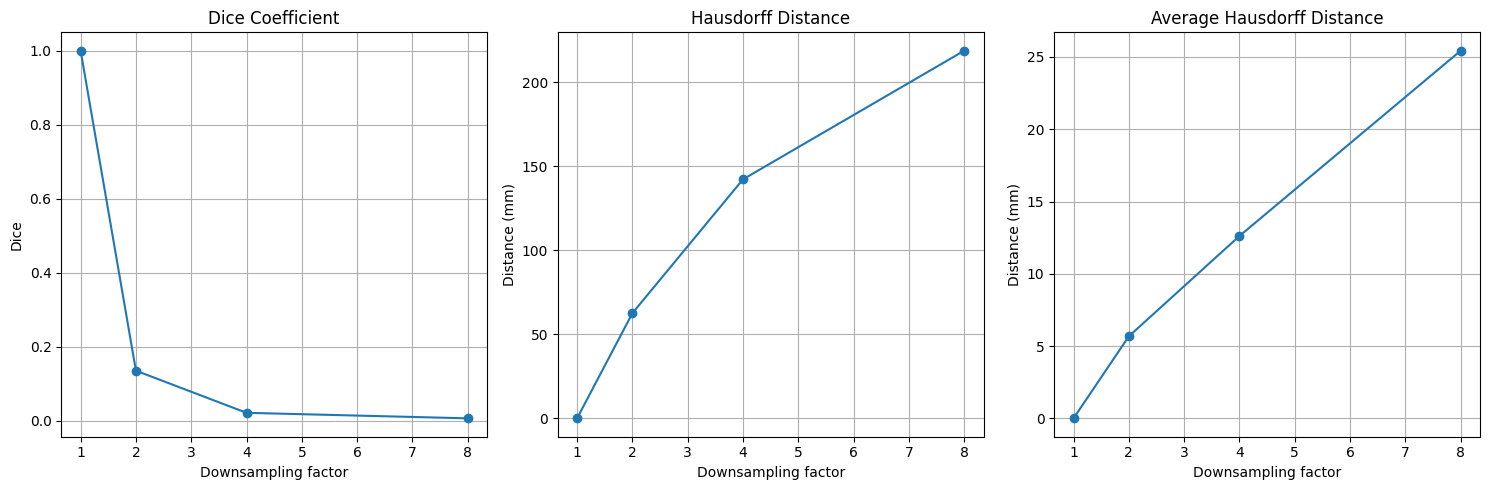

In [ ]:
'''
Il sottocampionamento è applicato alla maschera di riferimento per analizzare
l’effetto puramente geometrico della risoluzione sulla qualità del contorno,
isolandolo dalle incertezze dell’algoritmo di segmentazione.
'''

# =============================
# Parametri
# =============================
image_path = '/img1.nrrd'      # immagine originale (non usata direttamente qui)
label_path = '/img2.nrrd'      # ground truth (0 background, 1 foreground)

downsample_factors = [1, 2, 4, 8]
foreground_label = 1

# =============================
# Funzione di resampling
# =============================
def resample_to_original(img, factor, is_label=False):

    if factor == 1:
        return img

    original_spacing = img.GetSpacing()
    original_size = img.GetSize()

    # Downsampling → aumento dello spacing
    new_spacing = tuple(s * factor for s in original_spacing)

    new_size = tuple(
        max(1, int(round(os * os_spacing / ns)))
        for os, os_spacing, ns in zip(original_size, original_spacing, new_spacing)
    )

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputOrigin(img.GetOrigin())
    resampler.SetOutputDirection(img.GetDirection())
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)

    # Interpolazione corretta
    if is_label:
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resampler.SetInterpolator(sitk.sitkLinear)

    downsampled = resampler.Execute(img)

    # Upsampling alla griglia originale
    resampler.SetSize(original_size)
    resampler.SetOutputSpacing(original_spacing)

    return resampler.Execute(downsampled)

# =============================
# Caricamento immagini
# =============================
original_label = sitk.ReadImage(label_path, sitk.sitkUInt8)

gt = original_label == foreground_label

# =============================
# Calcolo metriche
# =============================
results = []

for factor in downsample_factors:
    print(f"Processing downsampling factor {factor}")

    resampled_label = resample_to_original(
        original_label, factor, is_label=True
    )

    pred = resampled_label == foreground_label

    # Dice
    overlap = sitk.LabelOverlapMeasuresImageFilter()
    overlap.Execute(gt, pred)
    dice = overlap.GetDiceCoefficient()

    # Hausdorff
    hausdorff = sitk.HausdorffDistanceImageFilter()
    hausdorff.Execute(gt, pred)

    hd = hausdorff.GetHausdorffDistance()
    avg_hd = hausdorff.GetAverageHausdorffDistance()

    results.append({
        'factor': factor,
        'dice': dice,
        'hausdorff': hd,
        'avg_hausdorff': avg_hd
    })

# =============================
# Risultati
# =============================
df = pd.DataFrame(results)
print(df)

# =============================
# Plot
# =============================
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(df['factor'], df['dice'], marker='o')
ax[0].set_title('Dice Coefficient')
ax[0].set_xlabel('Downsampling factor')
ax[0].set_ylabel('Dice')
ax[0].grid(True)

ax[1].plot(df['factor'], df['hausdorff'], marker='o')
ax[1].set_title('Hausdorff Distance')
ax[1].set_xlabel('Downsampling factor')
ax[1].set_ylabel('Distance (mm)')
ax[1].grid(True)

ax[2].plot(df['factor'], df['avg_hausdorff'], marker='o')
ax[2].set_title('Average Hausdorff Distance')
ax[2].set_xlabel('Downsampling factor')
ax[2].set_ylabel('Distance (mm)')
ax[2].grid(True)

plt.tight_layout()
plt.show()

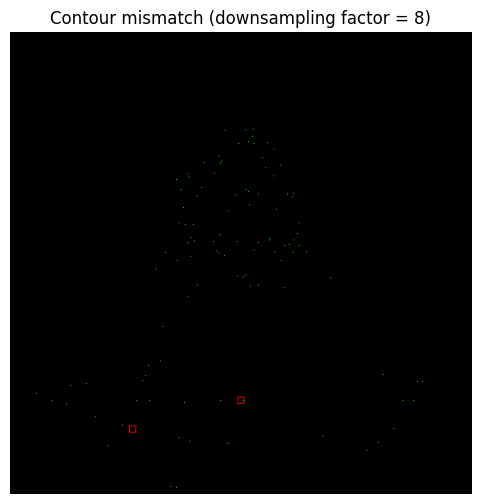

In [ ]:
# =============================
# Analisi qualitativa del contorno
# =============================

# scegliamo il caso peggiore (massimo sottocampionamento)
worst_factor = max(downsample_factors)

resampled_label = resample_to_original(
    original_label, worst_factor, is_label=True
)

gt = (original_label == foreground_label)
pred = (resampled_label == foreground_label)

# Estrazione del contorno tramite gradiente morfologico
contour_gt = sitk.LabelContour(gt)
contour_pred = sitk.LabelContour(pred)

# Conversione in numpy per visualizzazione
contour_gt_np = sitk.GetArrayFromImage(contour_gt)
contour_pred_np = sitk.GetArrayFromImage(contour_pred)

# Sovrapposizione errori
# Verde = contorno GT
# Rosso = contorno sottocampionato
error_map = np.zeros((*contour_gt_np.shape, 3))

error_map[..., 1] = contour_gt_np      # verde
error_map[..., 0] = contour_pred_np    # rosso

# scegli una slice significativa (3D) oppure tutto (2D)
slice_idx = contour_gt_np.shape[0] // 2

plt.figure(figsize=(6, 6))
plt.imshow(error_map[slice_idx])
plt.title(f'Contour mismatch (downsampling factor = {worst_factor})')
plt.axis('off')
plt.show()


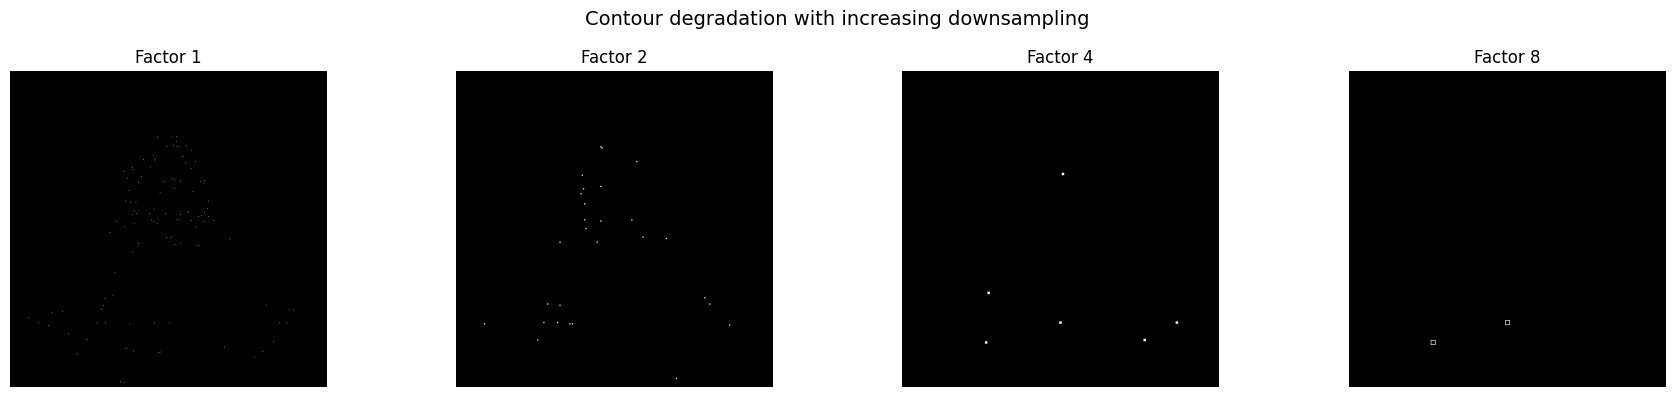

In [ ]:
# =============================
# Visualizzazione contorni a diverse risoluzioni
# =============================

fig, axes = plt.subplots(1, len(downsample_factors), figsize=(18, 4))

for ax, factor in zip(axes, downsample_factors):

    resampled_label = resample_to_original(
        original_label, factor, is_label=True
    )

    contour = sitk.LabelContour(resampled_label == foreground_label)
    contour_np = sitk.GetArrayFromImage(contour)

    slice_idx = contour_np.shape[0] // 2

    ax.imshow(contour_np[slice_idx], cmap='gray')
    ax.set_title(f'Factor {factor}')
    ax.axis('off')

plt.suptitle('Contour degradation with increasing downsampling', fontsize=14)
plt.tight_layout()
plt.show()


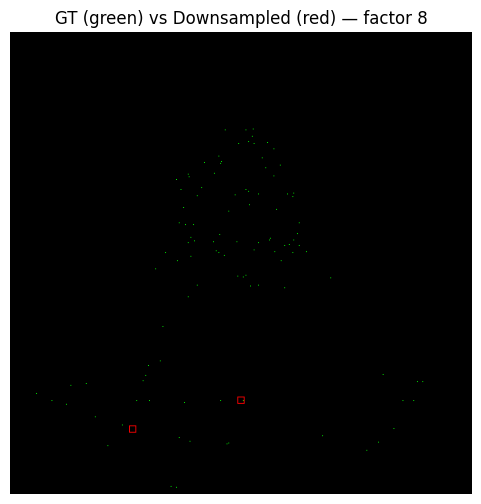

In [ ]:
# =============================
# Sovrapposizione GT vs predetto
# =============================

factor = max(downsample_factors)

resampled_label = resample_to_original(
    original_label, factor, is_label=True
)

gt = original_label == foreground_label
pred = resampled_label == foreground_label

contour_gt = sitk.LabelContour(gt)
contour_pred = sitk.LabelContour(pred)

gt_np = sitk.GetArrayFromImage(contour_gt)
pred_np = sitk.GetArrayFromImage(contour_pred)

slice_idx = gt_np.shape[0] // 2

overlay = np.zeros((*gt_np.shape, 3))
overlay[..., 1] = gt_np     # verde = GT
overlay[..., 0] = pred_np   # rosso = sottocampionato

plt.figure(figsize=(6, 6))
plt.imshow(overlay[slice_idx])
plt.title(f'GT (green) vs Downsampled (red) — factor {factor}')
plt.axis('off')
plt.show()


In [ ]:
# =============================
# Metriche complete di classificazione (segmentazione binaria)
# =============================

from sklearn.metrics import confusion_matrix

metrics_results = []

for factor in downsample_factors:

    resampled_label = resample_to_original(
        original_label, factor, is_label=True
    )

    gt = (original_label == foreground_label)
    pred = (resampled_label == foreground_label)

    # Flatten per metriche voxel-wise
    gt_flat = sitk.GetArrayFromImage(gt).ravel()
    pred_flat = sitk.GetArrayFromImage(pred).ravel()

    # Confusion matrix: TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(gt_flat, pred_flat, labels=[0, 1]).ravel()

    # Metriche standard
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    metrics_results.append({
        'Downsampling factor': factor,
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity,
        'F1-score': f1_score
    })

# =============================
# Output tabellare elegante
# =============================
metrics_df = pd.DataFrame(metrics_results)

# Arrotondiamo per leggibilità accademica
metrics_df.iloc[:, 1:] = metrics_df.iloc[:, 1:].round(4)

display(metrics_df.style
        .set_caption("Voxel-wise classification metrics for different downsampling factors")
        .background_gradient(cmap='Blues', axis=0)
        .format("{:.4f}")
)



,Downsampling factor,Accuracy,Precision,Sensitivity (Recall),Specificity,F1-score
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,2.0000,0.9988,0.1346,0.1368,0.9994,0.1357
2,4.0000,0.9986,0.0217,0.0221,0.9993,0.0219
3,8.0000,0.9985,0.0065,0.0075,0.9992,0.0070
